# Mnist dataset is loaded from github with initial setup

In [15]:
from pathlib import Path
import gzip
import pickle
import requests
import torch
import matplotlib.pyplot as plt


DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

PATH.mkdir(parents=True, exist_ok=True)

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin1")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device being used is: ', device)

x_train = torch.tensor(x_train, dtype=torch.float32, device=device) # Convert to tensors and move it to device
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
x_valid = torch.tensor(x_valid, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.long, device=device)


device being used is:  cuda


# Neural Network is initialised with initial weights and bias along with functions for activation like relu and softmax and also defined loss function to be cross entropy.

In [16]:

input_size = 784 # 28 x 28 pixels
hidden_size = 128 # arbitrarily defined
output_size = 10 # 0 to 9 output classes

def init_weights(shape):
    return torch.empty(shape, device=device).uniform_(-0.01, 0.01).requires_grad_()

W1 = init_weights((input_size, hidden_size))
b1 = init_weights((hidden_size,))
W2 = init_weights((hidden_size, output_size))
b2 = init_weights((output_size,))


def relu(x):
    return torch.maximum(x, torch.tensor(0.0, device=device))

def softmax(x):
    exps = torch.exp(x - x.max(dim=1, keepdim=True).values)
    return exps / exps.sum(dim=1, keepdim=True)

def cross_entropy(preds, targets):
    return -torch.log(preds[range(len(targets)), targets]).mean()

def accuracy(preds, targets):
    return (preds.argmax(dim=1) == targets).float().mean()


# Training and validating the model

In [17]:
lr = 0.1
epochs = 10
bs = 256 #batch size

train_accs, val_accs = [], []

for epoch in range(epochs):
    permutation = torch.randperm(x_train.size(0)) # .size(0) means number of rows
    total_loss, total_acc = 0, 0

    for i in range(0, x_train.size(0), bs):
        idx = permutation[i:i+bs]
        xb = x_train[idx]
        yb = y_train[idx]


        h = relu(xb @ W1 + b1) # @ means matrix multiplication xb-> 256(bs)x784 and W1 -> 784x128(hidde layer)
        out = h @ W2 + b2 # h -> 256x128 (output of hidden layer) and W2 -> 128x10(output)
        probs = softmax(out)
        loss = cross_entropy(probs, yb)
        total_loss += loss.item()

        acc = accuracy(probs, yb)
        total_acc += acc.item()


        loss.backward()  #automatic differentiation (Back propagation)

        with torch.no_grad(): #Temporarily disables gradient tracking inside this block. and Saves memory and avoids PyTorch messing with the update operation itself.
            W1 -= lr * W1.grad  # W1.grad -> the gradient of the loss with respect to W1
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            # above ones are used to calculate manual gradient descent
            W1.grad.zero_()
            b1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()
            # need to reset gradients to zero


    with torch.no_grad(): # Validation
        val_h = relu(x_valid @ W1 + b1)
        val_out = val_h @ W2 + b2
        val_probs = softmax(val_out)
        val_acc = accuracy(val_probs, y_valid).item()

    train_accs.append(total_acc * bs / len(x_train))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_acc:.4f}")



Epoch 1 | Train Loss: 271.1458 | Train Acc: 0.6221 | Val Acc: 0.8601
Epoch 2 | Train Loss: 88.9022 | Train Acc: 0.8803 | Val Acc: 0.8976
Epoch 3 | Train Loss: 70.4996 | Train Acc: 0.9017 | Val Acc: 0.9147
Epoch 4 | Train Loss: 63.0264 | Train Acc: 0.9119 | Val Acc: 0.9189
Epoch 5 | Train Loss: 58.0481 | Train Acc: 0.9192 | Val Acc: 0.9248
Epoch 6 | Train Loss: 54.0861 | Train Acc: 0.9245 | Val Acc: 0.9297
Epoch 7 | Train Loss: 50.7145 | Train Acc: 0.9292 | Val Acc: 0.9312
Epoch 8 | Train Loss: 47.6603 | Train Acc: 0.9346 | Val Acc: 0.9367
Epoch 9 | Train Loss: 44.7177 | Train Acc: 0.9393 | Val Acc: 0.9434
Epoch 10 | Train Loss: 42.1854 | Train Acc: 0.9427 | Val Acc: 0.9417


# Evaluating on the test set

In [18]:
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=device)

    test_h = relu(x_test_tensor @ W1 + b1)
    test_out = test_h @ W2 + b2
    test_probs = softmax(test_out)

    test_acc = accuracy(test_probs, y_test_tensor).item()

print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


Final Test Accuracy: 93.66%


# Plotting Train and validation accuracies

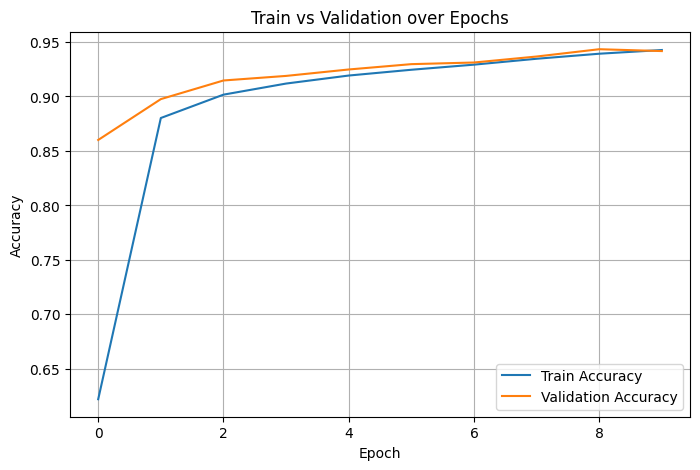

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation over Epochs")
plt.legend()
plt.grid(True)
plt.show()


# Task 2: Hyperparameter case study for 6CP
We have chosen **Hidden Layer Size** as our hyperparameter. We have taken the sizes from extremely small to extremely large to understand the effect of the hidden layer size in Deep Neural Networks.

Below are the considered Hidden Layer Sizes for our case study.
hidden sizes = [1, 32, 64, 128, 157, 314, 470, 628, 784, 1000].

Observation from this case study:
As the hidden layer size increases, the validation accuracy improves significantly especially after size 16. Smaller hidden sizes like those with just 1 or 4 really struggle to learn and it performs poorly. Once we go beyond 64 units, the models start to perform consistently well and converge quickly. One important finding that we came across was that after around 314 units, the improvement in accuracy becomes very minimal and therefore adding more neurons beyond that point does not really makes sense and it does not give us much benefit and just adds to the computational cost.

In [20]:
import time

hidden_sizes = [1, 4, 8, 16, 32, 64, 128, 157, 314, 470, 628, 784, 1000]
epochs = 10
lr = 0.1
bs = 256

val_accuracies = {}
training_times = {}

for hidden_size in hidden_sizes:
    print(f"\n Training model with hidden_size = {hidden_size}")
    start_time = time.time()

    # Initialize weights and biases
    def init_weights(shape):
        return torch.empty(shape, device=device).uniform_(-0.01, 0.01).requires_grad_()

    W1 = init_weights((784, hidden_size))
    b1 = init_weights((hidden_size,))
    W2 = init_weights((hidden_size, 10))
    b2 = init_weights((10,))

    val_accs = []

    for epoch in range(epochs):
        permutation = torch.randperm(x_train.size(0))

        for i in range(0, x_train.size(0), bs):
            idx = permutation[i:i+bs]
            xb = x_train[idx]
            yb = y_train[idx]

            h = relu(xb @ W1 + b1)
            out = h @ W2 + b2
            probs = softmax(out)
            loss = cross_entropy(probs, yb)

            loss.backward()

            with torch.no_grad():
                W1 -= lr * W1.grad
                b1 -= lr * b1.grad
                W2 -= lr * W2.grad
                b2 -= lr * b2.grad

                W1.grad.zero_()
                b1.grad.zero_()
                W2.grad.zero_()
                b2.grad.zero_()


        with torch.no_grad():
            val_h = relu(x_valid @ W1 + b1)
            val_out = val_h @ W2 + b2
            val_probs = softmax(val_out)
            val_acc = accuracy(val_probs, y_valid).item()
            val_accs.append(val_acc)

        print(f"  Epoch {epoch+1}/{epochs} | Validation Accuracy: {val_acc:.4f}")

    elapsed_time = time.time() - start_time
    val_accuracies[hidden_size] = val_accs
    training_times[hidden_size] = elapsed_time

    print(f" Finished training with hidden_size={hidden_size}")
    print(f"  Time taken: {elapsed_time:.2f} seconds")
    print(f" Validation Accuracies: {val_accs}")



 Training model with hidden_size = 1
  Epoch 1/10 | Validation Accuracy: 0.2119
  Epoch 2/10 | Validation Accuracy: 0.2430
  Epoch 3/10 | Validation Accuracy: 0.2641
  Epoch 4/10 | Validation Accuracy: 0.3000
  Epoch 5/10 | Validation Accuracy: 0.3049
  Epoch 6/10 | Validation Accuracy: 0.2977
  Epoch 7/10 | Validation Accuracy: 0.2941
  Epoch 8/10 | Validation Accuracy: 0.3046
  Epoch 9/10 | Validation Accuracy: 0.2917
  Epoch 10/10 | Validation Accuracy: 0.3042
 Finished training with hidden_size=1
  Time taken: 3.71 seconds
 Validation Accuracies: [0.211899995803833, 0.24300000071525574, 0.26409998536109924, 0.29999998211860657, 0.30489999055862427, 0.2976999878883362, 0.29409998655319214, 0.3046000003814697, 0.29170000553131104, 0.3041999936103821]

 Training model with hidden_size = 4
  Epoch 1/10 | Validation Accuracy: 0.5944
  Epoch 2/10 | Validation Accuracy: 0.7882
  Epoch 3/10 | Validation Accuracy: 0.8308
  Epoch 4/10 | Validation Accuracy: 0.8469
  Epoch 5/10 | Validation 

# Plotting for Validation accuracies for different Hidden layer sizes

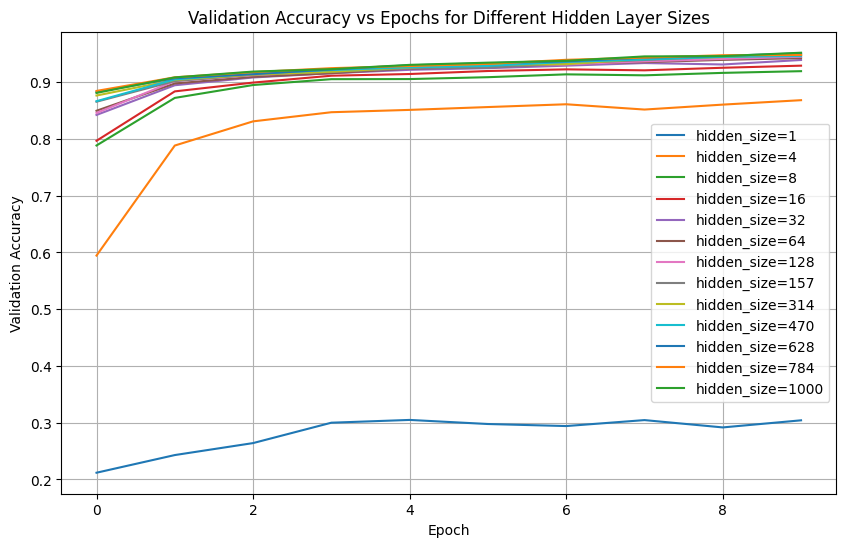

In [21]:
plt.figure(figsize=(10, 6))
for hs, accs in val_accuracies.items():
    plt.plot(accs, label=f"hidden_size={hs}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Epochs for Different Hidden Layer Sizes")
plt.legend()
plt.grid(True)
plt.show()
